In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import skorch
import torch
from skorch import NeuralNetClassifier
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from scipy.stats import entropy
import random
import h5py
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import FeatureAgglomeration

In [2]:


# Compare Algorithmsa
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [3]:
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, classification_report,confusion_matrix, accuracy_score, balanced_accuracy_score, cohen_kappa_score, f1_score,  precision_score, recall_score
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


def classification_complete_report(y_true, y_pred ,labels = None  ): 
    print(classification_report(y_true, y_pred, labels = labels))
    print(15*"----")
    print("matthews correlation coeff: %.4f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.4f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.4f & balanced Accuracy: %.4f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.4f & micro F1 score: %.4f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.4f & micro Precision score: %.4f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.4f & micro Recall score: %.4f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    cm = confusion_matrix(y_true, y_pred,labels= labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    print(15*"----")

In [4]:
metadata = pd.read_csv("/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_data_features/metadata_subset.csv.gz")
metadata

df_features = pd.read_csv("/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_data_features/df_features_subset.csv.gz")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
metadata["key"] = metadata["experiment"] + "_" + metadata["donor"] 

In [6]:
set_of_interesting_classes = ['B_cell',  'T_cell', 
                        'T_cell_with_signaling',
                        'T_cell_with_B_cell_fragments',
                        'B_T_cell_in_one_layer',
                        'Synapses_without_signaling', 
                        'Synapses_with_signaling',
                        'No_cell_cell_interaction', 
                        'Multiplets']

In [7]:


label_map = dict()
for i, cl in enumerate(set_of_interesting_classes):
    label_map[cl] = i
label_map['-1'] = -1
label_map[-1] = -1

inv_map = {v: k for k, v in label_map.items()}

In [8]:
inv_map


{0: 'B_cell',
 1: 'T_cell',
 2: 'T_cell_with_signaling',
 3: 'T_cell_with_B_cell_fragments',
 4: 'B_T_cell_in_one_layer',
 5: 'Synapses_without_signaling',
 6: 'Synapses_with_signaling',
 7: 'No_cell_cell_interaction',
 8: 'Multiplets',
 -1: -1}

In [9]:
labeled_index = metadata["label"].isin(set_of_interesting_classes)

train_index = metadata["set"] == "train"
train_index = train_index[train_index].index

validation_index = metadata["set"] == "validation"
validation_index = validation_index[validation_index].index

test_index = metadata["set"] == "test"
test_index = test_index[test_index].index

In [10]:
df_predictions = pd.DataFrame()
df_predictions["label"] = metadata.loc[test_index,"label"]

deepflow_preds = pd.read_csv("ml_and_dl_models/deepflow/deepflow_preds.csv").loc[:,"0"].tolist()
deepflow_preds = [inv_map[x] for x in deepflow_preds]
df_predictions["deepflow_preds"] = deepflow_preds

resnet18_preds = pd.read_csv("ml_and_dl_models/resnet18 with imagenet pretrained/resnet18_preds.csv").loc[:,"0"].tolist()
resnet18_preds = [inv_map[x] for x in resnet18_preds]
df_predictions["resnet18_preds"] = resnet18_preds

resnet34_preds = pd.read_csv("ml_and_dl_models/resnet34 with imagenet pretrained/resnet34_preds.csv").loc[:,"0"].tolist()
resnet34_preds = [inv_map[x] for x in resnet34_preds]
df_predictions["resnet34_preds"] = resnet34_preds

ae_preds = pd.read_csv("ml_and_dl_models/autoencoder features with LR/ae_preds.csv").loc[:,"0"].tolist()
ae_preds = [inv_map[x] for x in ae_preds]
df_predictions["ae_preds"] = ae_preds


LR_preds = pd.read_csv("ml_and_dl_models/interpretable features with LR/LR_preds.csv").loc[:,"0"].tolist()
df_predictions["LR_preds"] = LR_preds

XGBoost_preds = pd.read_csv("ml_and_dl_models/interpretable features with XGBoost/XGBoost_preds.csv").loc[:,"0"].tolist()
df_predictions["XGBoost_preds"] = XGBoost_preds

In [11]:
df_predictions = df_predictions.reset_index(drop = True)

In [12]:
from sklearn.model_selection import RepeatedStratifiedKFold

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

predictor_results = pd.DataFrame(columns=["Model", "Macro f1-score", "Accuracy"])

for _, fold_test_index in rskf.split(df_predictions.index, df_predictions.label):
    
    predictor_results = predictor_results.append({
        "Model" : "deepflow", 
        "Macro f1-score": f1_score(df_predictions.loc[fold_test_index,"label"],
                                   df_predictions.loc[fold_test_index,"deepflow_preds"], average="macro"  ), 
        "Accuracy": accuracy_score(df_predictions.loc[fold_test_index,"label"],
                                   df_predictions.loc[fold_test_index,"deepflow_preds"])
    }, ignore_index = True)
    
    predictor_results = predictor_results.append({
        "Model" : "resnet18", 
        "Macro f1-score": f1_score(df_predictions.loc[fold_test_index,"label"],
                                   df_predictions.loc[fold_test_index,"resnet18_preds"], average="macro"  ), 
        "Accuracy": accuracy_score(df_predictions.loc[fold_test_index,"label"],
                                   df_predictions.loc[fold_test_index,"resnet18_preds"])
    }, ignore_index = True)
    
    predictor_results = predictor_results.append({
        "Model" : "resnet34", 
        "Macro f1-score": f1_score(df_predictions.loc[fold_test_index,"label"],
                                   df_predictions.loc[fold_test_index,"resnet34_preds"], average="macro"  ), 
        "Accuracy": accuracy_score(df_predictions.loc[fold_test_index,"label"],
                                   df_predictions.loc[fold_test_index,"resnet34_preds"])
    }, ignore_index = True)
    
    predictor_results = predictor_results.append({
        "Model" : "ae", 
        "Macro f1-score": f1_score(df_predictions.loc[fold_test_index,"label"],
                                   df_predictions.loc[fold_test_index,"ae_preds"], average="macro"  ), 
        "Accuracy": accuracy_score(df_predictions.loc[fold_test_index,"label"],
                                   df_predictions.loc[fold_test_index,"ae_preds"])
    }, ignore_index = True)
    
    predictor_results = predictor_results.append({
        "Model" : "lr", 
        "Macro f1-score": f1_score(df_predictions.loc[fold_test_index,"label"],
                                   df_predictions.loc[fold_test_index,"LR_preds"], average="macro"  ), 
        "Accuracy": accuracy_score(df_predictions.loc[fold_test_index,"label"],
                                   df_predictions.loc[fold_test_index,"LR_preds"])
    }, ignore_index = True)
    
    predictor_results = predictor_results.append({
        "Model" : "xgb", 
        "Macro f1-score": f1_score(df_predictions.loc[fold_test_index,"label"],
                                   df_predictions.loc[fold_test_index,"XGBoost_preds"], average="macro"  ), 
        "Accuracy": accuracy_score(df_predictions.loc[fold_test_index,"label"],
                                   df_predictions.loc[fold_test_index,"XGBoost_preds"])
    }, ignore_index = True)


In [13]:

predictor_results

,Model,Macro f1-score,Accuracy
0,deepflow,0.903965,0.907643
1,resnet18,0.885509,0.888535
2,resnet34,0.915811,0.917197
3,ae,0.783470,0.792994
4,lr,0.903726,0.907643
...,...,...,...
295,resnet18,0.918718,0.920128
296,resnet34,0.926833,0.929712
297,ae,0.792325,0.798722
298,lr,0.898387,0.900958


In [14]:
predictor_results.groupby(["Model"]).mean().sort_values("Macro f1-score",  ascending=False).index

Index(['xgb', 'resnet34', 'deepflow', 'resnet18', 'lr', 'ae'], dtype='object', name='Model')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: 
The palette list has fewer values (1) than needed (6) and will cycle, which may produce an uninterpretable plot.
  # This is added back by InteractiveShellApp.init_path()


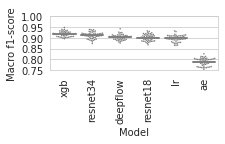

In [15]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize = (3,1)) 

key_order = ['xgb', 'resnet34', 'deepflow', 'resnet18', 'lr', 'ae']

ax = sns.swarmplot(data=predictor_results,x = "Model", 
            y = "Macro f1-score", 
            palette=["Grey"],
                   s = 1.52,
            order = key_order, 
                   ax = ax)

ax = sns.boxplot(
    showmeans=True,
            meanline=True,
            meanprops={'color': 'grey', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="Model",
            y="Macro f1-score", 
            order = key_order,
            data=predictor_results,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)

ax.set_xticklabels(key_order, rotation = 90)

plt.ylim(0.75, 
         1.00)

plt.yticks([0.75,0.80,0.85,0.90,0.95,1.00])

plt.savefig("Figure - Comparison of different classifers.svg")
plt.savefig("Figure - Comparison of different classifers.png")

In [16]:
for k in key_order:
    indx = predictor_results.Model == k
    print(k, 
          "mean", round(predictor_results.loc[indx, "Macro f1-score"].mean(),2),
         "std", round(predictor_results.loc[indx, "Macro f1-score"].std(),2)           )

xgb mean 0.92 std 0.01
resnet34 mean 0.91 std 0.01
deepflow mean 0.9 std 0.01
resnet18 mean 0.9 std 0.02
lr mean 0.9 std 0.02
ae mean 0.79 std 0.02


## Donor cross validation & experiment cross validation

In [17]:
list_of_features_to_exclude = ["Antibody","Live-Dead","CD18",  "_R2",  "_R3",  "_R8", "background",
                               "moment","percent","mask_based_mean","mask_based_min","mask_based_max",  
                               "RMS","intensity_BF","_R1_R2","_R1_R3","_R1_R4","_R1_R5","_R1_R6","_R1_R7",
                               "_R1_R8","_R2_R1","_R2_R3","_R2_R4","_R2_R5","_R2_R6","_R2_R7","_R2_R8",
                               "_R3_R1","_R3_R2","_R3_R4","_R3_R5","_R3_R6","_R3_R7","_R3_R8",
                               "_R4_R1","_R4_R2","_R4_R3","_R4_R5","_R4_R6","_R4_R7","_R4_R8",
                               "_R5_R1","_R5_R2","_R5_R3","_R5_R4","_R5_R8","_R6_R1","_R6_R2",
                               "_R6_R3","_R6_R4","_R6_R5","_R6_R7","_R6_R8","_R7_R1","_R7_R2",
                               "_R7_R3","_R7_R4","_R7_R5","_R7_R6","_R7_R8","_R8_R1","_R8_R2",
                               "_R8_R3","_R8_R4","_R8_R5","_R8_R6","_R8_R7","cell_distance"]
classification_indx = ~df_features.columns.str.contains( list_of_features_to_exclude[0]) 

for f_to_exclude in list_of_features_to_exclude:
    classification_indx = classification_indx & ~df_features.columns.str.contains( f_to_exclude) 
    

print("list of remained columns:\n", 
      df_features.columns[classification_indx],
     "\n",
     "so we have these many columns:",
     classification_indx.sum())

list of remained columns:
 Index(['mask_based_area_BF', 'mask_based_bbox_area_BF',
       'mask_based_convex_area_BF', 'mask_based_eccentricity_BF',
       'mask_based_equivalent_diameter_BF', 'mask_based_euler_number_BF',
       'mask_based_extent_BF', 'mask_based_feret_diameter_max_BF',
       'mask_based_filled_area_BF', 'mask_based_major_axis_length_BF',
       ...
       'max_intensity_ratio_F-Actin_R5_R7', 'sum_intensity_ratio_MHCII_R5_R7',
       'mean_intensity_ratio_MHCII_R5_R7', 'max_intensity_ratio_MHCII_R5_R7',
       'sum_intensity_ratio_CD3_R5_R7', 'mean_intensity_ratio_CD3_R5_R7',
       'max_intensity_ratio_CD3_R5_R7', 'sum_intensity_ratio_P-CD3zeta_R5_R7',
       'mean_intensity_ratio_P-CD3zeta_R5_R7',
       'max_intensity_ratio_P-CD3zeta_R5_R7'],
      dtype='object', length=247) 
 so we have these many columns: 247


In [18]:
label_map = dict()
for i, cl in enumerate(set_of_interesting_classes):
    label_map[cl] = i

label_map['-1'] = -1
label_map[-1] = -1

print(label_map)

{'B_cell': 0, 'T_cell': 1, 'T_cell_with_signaling': 2, 'T_cell_with_B_cell_fragments': 3, 'B_T_cell_in_one_layer': 4, 'Synapses_without_signaling': 5, 'Synapses_with_signaling': 6, 'No_cell_cell_interaction': 7, 'Multiplets': 8, '-1': -1, -1: -1}


In [19]:
from sklearn.pipeline import Pipeline
from scifAI.ml.auto_feature_selection import AutoFeatureSelection
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
from sklearn.linear_model import LogisticRegressionCV

labeled_index = metadata["label"].isin(set_of_interesting_classes)
labeled_index = labeled_index &  metadata["set"].isin(["train","validation", "test"])

scores = []
top_k = 130

for key in metadata.loc[:,"key"].unique():
    print(key)
    group_val = metadata.key.isin([key])
    group_val = group_val & labeled_index

    group_train = ~metadata.key.isin([key])
    group_train = group_train & labeled_index

    if group_train.sum()*group_val.sum():
    
        xgb = Pipeline([
                        ('StandardScaler', StandardScaler()), 
#                         ('AutoFeatureSelection', AutoFeatureSelection( top_k = top_k , verbose=False)),''
                         ('xgb', XGBClassifier(n_jobs = -1, 
                                       n_estimators = 100, 
                                       eval_metric = "logloss") )
                ], verbose=False)
        xgb = xgb.fit(df_features.loc[group_train,classification_indx],
                      metadata.loc[group_train,"label"].replace(label_map))

        y_pred = xgb.predict(df_features.loc[group_val,classification_indx])
        y_true = metadata.loc[group_val,"label"].replace(label_map)

        scores.append({key:f1_score(y_true,y_pred,average="macro")})


Experiment_1_Donor_1
Experiment_1_Donor_2
Experiment_2_Donor_3
Experiment_2_Donor_4
Experiment_3_Donor_1
Experiment_3_Donor_5
Experiment_3_Donor_6
Experiment_4_Donor_2
Experiment_4_Donor_7
Experiment_4_Donor_8
Experiment_4_Donor_9


In [20]:
scores = pd.melt(pd.DataFrame(scores)).dropna().reset_index(drop=True)

scores["experiment"] =scores["variable"]

for donor in metadata.donor.unique():
    scores["experiment"] = scores["experiment"].str.replace("_"+donor,"")
    
scores["variable"] = "f1_macro"

In [21]:
scores

,variable,value,experiment
0,f1_macro,0.897533,Experiment_1
1,f1_macro,0.810833,Experiment_1
2,f1_macro,0.874518,Experiment_2
3,f1_macro,0.847031,Experiment_3
4,f1_macro,0.882509,Experiment_3
5,f1_macro,0.888649,Experiment_4
6,f1_macro,0.926260,Experiment_4
7,f1_macro,0.940721,Experiment_4


In [22]:
print("f1_macro:",
      "median",
      scores.value.median().round(2),
      "mean",
      scores.value.mean().round(2),
      "std",
      scores.value.std().round(2))

f1_macro: median 0.89 mean 0.88 std 0.04


/home/shetabs1/.local/lib/python3.7/site-packages/seaborn/_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


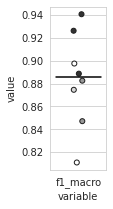

In [23]:

fig,ax =plt.subplots(figsize=(1,3))

ax=sns.stripplot(data = scores , 
                       x = "variable",
                       y = "value", 
                       hue = "experiment", 
                       hue_order = [
                                    "Experiment_1",
                                    "Experiment_2",
                                    "Experiment_3",
                                    "Experiment_4"],
                       s = 5,
                       linewidth=1,
#                        split = True,
                      palette=np.array([(1,1,1 ),
                                        (0.85, 0.85, 0.85 ),
                                        (0.60, 0.60, 0.60 ),
                                        (0.2,0.2,0.2 )]),
                       dodge=False,
                      ax = ax) 


ax = sns.boxplot(
            data = scores , 
                       x = "variable",
                       y = "value", 
            whiskerprops={'visible': False},
            zorder=10,
            palette=["black"],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)
ax.legend().remove()

plt.savefig('Supplementary Figure - donor cross validation.svg', bbox_inches="tight")
plt.savefig('Supplementary Figure - donor cross validation.png', bbox_inches="tight")

In [24]:
label_map

{'B_cell': 0,
 'T_cell': 1,
 'T_cell_with_signaling': 2,
 'T_cell_with_B_cell_fragments': 3,
 'B_T_cell_in_one_layer': 4,
 'Synapses_without_signaling': 5,
 'Synapses_with_signaling': 6,
 'No_cell_cell_interaction': 7,
 'Multiplets': 8,
 '-1': -1,
 -1: -1}